# Autor: Matheus Magalh√£es 
### Tarefa Aprendizado N√£o Supervisionado

In [251]:
# Importando as bibliotecas necess√°rias:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

### Tratamento e Limpeza dos Dados
Come√ßarei fazendo a limpeza e o tratamento dos dados do **.csv**.

In [254]:
# Importando o .csv:
df = pd.read_csv("credit_card_customer_data.csv")

In [256]:
# Vendo a estrutura do df:
df.head()

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
0      1         87073            100000                   2   
1      2         38414             50000                   3   
2      3         17341             50000                   7   
3      4         40496             30000                   5   
4      5         47437            100000                   6   

   Total_visits_bank  Total_visits_online  Total_calls_made  
0                  1                    1                 0  
1                  0                   10                 9  
2                  1                    3                 4  
3                  1                    1                 4  
4                  0                   12                 3

In [258]:
# Verificando formato do df:
print(f"Dimens√µes da matriz: {df.shape} \n")

# Verificando dados nulos:
print(f"N√∫meros de nulos por atributo:\n{df.isna().sum()}\n")

# Verificando dados duplicados:
print(f"Dados duplicados por atributo:\n{df.nunique()}\n")

# Verificando os tipos de dados:
print(f"Tipos de dados por atributo:\n{df.dtypes}\n")

Dimens√µes da matriz: (660, 7) 

N√∫meros de nulos por atributo:
Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

Dados duplicados por atributo:
Sl_No                  660
Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

Tipos de dados por atributo:
Sl_No                  int64
Customer Key           int64
Avg_Credit_Limit       int64
Total_Credit_Cards     int64
Total_visits_bank      int64
Total_visits_online    int64
Total_calls_made       int64
dtype: object



### Conclus√µes iniciais
O DataFrame n√£o possi valores nulos ou inv√°lidos. No entanto, possui 5 "Customer Key" repetidas, portanto, vou verificar quais s√£o e perceber se elas s√£o linhas id√™nticas ou n√£o.

In [261]:
# Printando as 'customer_key' duplicadas:
duplicadas = df[df['Customer Key'].duplicated(keep=False)]
duplicadas.sort_values('Customer Key')

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
48      49         37252              6000                   4   
432    433         37252             59000                   6   
4        5         47437            100000                   6   
332    333         47437             17000                   7   
411    412         50706             44000                   4   
541    542         50706             60000                   7   
391    392         96929             13000                   4   
398    399         96929             67000                   6   
104    105         97935             17000                   2   
632    633         97935            187000                   7   

     Total_visits_bank  Total_visits_online  Total_calls_made  
48                   0                    2                 8  
432                  2                    1                 2  
4                    0                   12                 3  
332                  3                    1                 0  
411                  5                    0                 2  
541                  5                    2                 2  
391                  5                    0                 0  
398                  2                    2                 2  
104                  1                    2                10  
632                  1                    7                 0

Estou supondo que essas duplicatas s√£o dados extra√≠dos, do mesmo cliente, em √©pocas distintas. Por isso, vou agregar estes dados pelo .max(), pois, a tend√™ncia √© que, com o passar dos anos, seu limite, total de cart√µes, visitas ao banco, etc., aumentem. 

In [264]:
# Agregando pela 'Customer Key':
df = df.groupby('Customer Key').agg({
    'Avg_Credit_Limit': 'max',
    'Total_Credit_Cards': 'max',
    'Total_visits_bank': 'max',
    'Total_visits_online': 'max',
    'Total_calls_made': 'max'
}).reset_index()

Repare que, como agreguei pela **'Customer Key'**, o atributo **'Sl_No'** (*Serial Number*) ser√° descartado, e os clientes ser√£o identificados somente pela **'Customer Key'**.

In [267]:
# Verificando se, de fato, n√£o existem repeti√ß√µes em 'Customer Key':
print(f"Valores √∫nicos em 'Customer Key': {df['Customer Key'].nunique()}")
print(f"Total de linhas no DF: {df.shape[0]}")

Valores √∫nicos em 'Customer Key': 655
Total de linhas no DF: 655


Como podemos ver pela c√©lula acima, n√£o existem valores repetidos em **'Customer Key'**. Sendo assim, **'Customer Key'** √© uma **chave identificadora** v√°lida.

In [270]:
# M√©tricas √∫teis sobre o df:
df.describe()

Customer Key  Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
count    655.000000        655.000000           655.00000         655.000000   
mean   55058.158779      34690.076336             4.71145           2.409160   
std    25606.965469      37728.591465             2.17241           1.628467   
min    11265.000000       3000.000000             1.00000           0.000000   
25%    33623.500000      10000.000000             3.00000           1.000000   
50%    53898.000000      18000.000000             5.00000           2.000000   
75%    77084.500000      48500.000000             6.00000           4.000000   
max    99843.000000     200000.000000            10.00000           5.000000   

       Total_visits_online  Total_calls_made  
count           655.000000        655.000000  
mean              2.619847          3.604580  
std               2.941931          2.864575  
min               0.000000          0.000000  
25%               1.000000          1.000000  
50%               2.000000          3.000000  
75%               4.000000          5.000000  
max              15.000000         10.000000

### Gr√°ficos

In [273]:
sns.set(style="whitegrid")

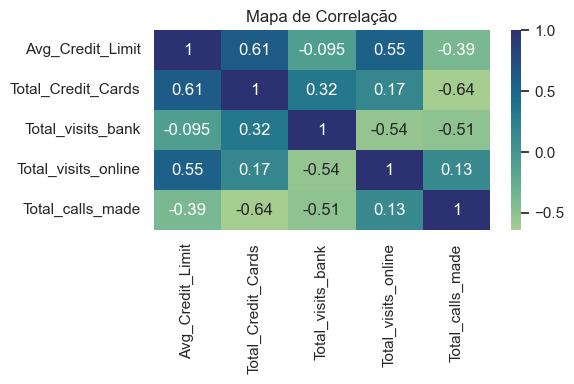

In [275]:
# Matriz de correla√ß√£o das vari√°veis:
plt.figure(figsize=(6, 4))
corr = df[['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']].corr()
sns.heatmap(corr, annot=True, cmap='crest')
plt.title('Mapa de Correla√ß√£o')
plt.tight_layout()
plt.show()

### An√°lise de Correla√ß√£o entre Vari√°veis

A matriz de correla√ß√£o revelou algumas rela√ß√µes significativas entre os atributos do conjunto de dados:

1. **Avg_Credit_Limit** possui uma correla√ß√£o positiva forte com **Total_Credit_Cards** (0.61), sugerindo que clientes com mais cart√µes de cr√©dito tendem a ter um limite m√©dio maior.

2. **Avg_Credit_Limit** tamb√©m apresenta uma correla√ß√£o positiva moderada com **Total_visits_online** (0.55), o que pode indicar que clientes com maior limite utilizam mais o ambiente digital.

3. **Avg_Credit_Limit** possui ainda uma correla√ß√£o negativa moderada com **Total_calls_made** (-0.39), indicando que clientes com maior limite m√©dio fazem menos chamadas para o banco.

4. **Total_Credit_Cards** e **Total_visits_bank** apresentam uma correla√ß√£o positiva moderada (0.32), sugerindo que clientes com mais cart√µes tendem a visitar mais o banco fisicamente.

5. **Total_Credit_Cards** e **Total_calls_made** apresentam uma correla√ß√£o negativa forte (-0.64), sugerindo que clientes com mais cart√µes tendem a realizar menos chamadas.

6. **Total_visits_bank** e **Total_visits_online** t√™m uma correla√ß√£o negativa significativa (-0.54), indicando uma substitui√ß√£o entre os canais de atendimento: clientes que visitam mais o banco fisicamente tendem a acessar menos os canais digitais, e vice-versa.

7. **Total_calls_made** tamb√©m apresenta correla√ß√£o negativa com **Total_visits_bank** (-0.51), sugerindo que mais chamadas podem estar associadas a um menor envolvimento presencial com a ag√™ncia banc√°ria.


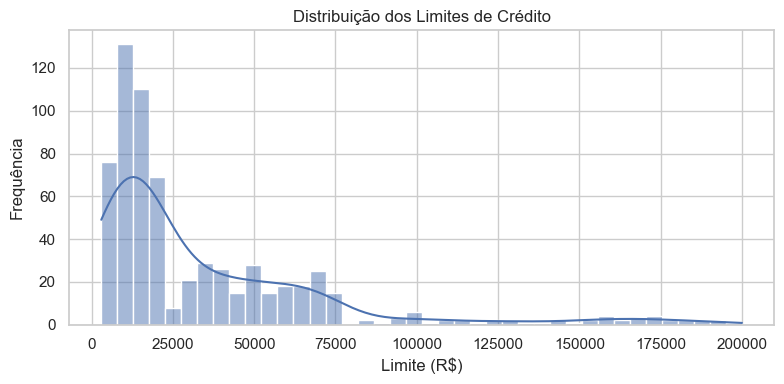

In [278]:
# Histograma dos limites de cr√©dito:
plt.figure(figsize=(8, 4))
sns.histplot(df['Avg_Credit_Limit'], bins=40, kde=True)
plt.title('Distribui√ß√£o dos Limites de Cr√©dito')
plt.xlabel('Limite (R$)')
plt.ylabel('Frequ√™ncia')
plt.tight_layout()
plt.show()

In [280]:
# Histograma do n√∫mero de cart√µes:
plt.figure(figsize=(8, 4))
sns.histplot(df['Total_Credit_Cards'], bins=40, kde=True)
plt.title('Distribui√ß√£o do N√∫mero de Cart√µes de Cr√©dito')
plt.xlabel('N√∫mero de Cart√µes')
plt.ylabel('Frequ√™ncia')
plt.tight_layout()
plt.show()

In [282]:
# Boxplot dos limites por n√∫mero de cart√µes:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Total_Credit_Cards', y='Avg_Credit_Limit')
plt.xticks(rotation=45)
plt.title('Limite de Cr√©dito por N√∫mero de Cart√µes')
plt.tight_layout()
plt.show()

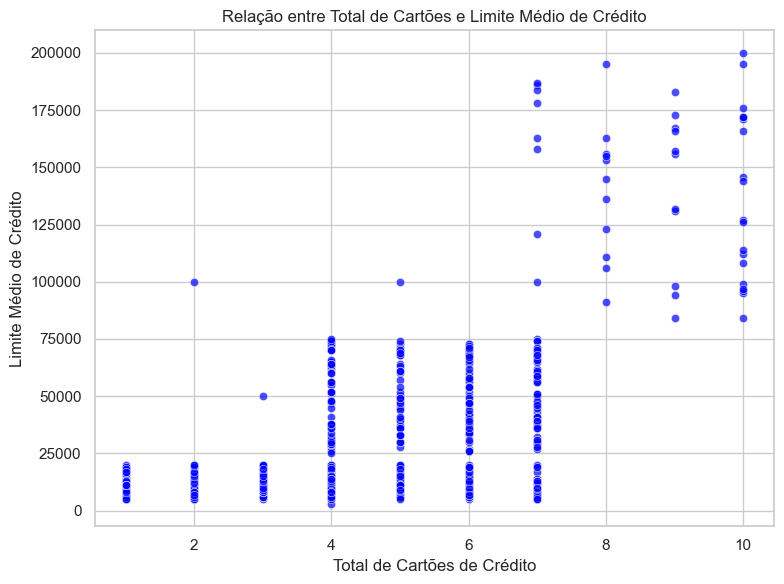

In [284]:
# Scatter plot entre 'Avg_Credit_Limit' e 'Total_Credit_Cards':
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="Total_Credit_Cards", y="Avg_Credit_Limit", color="blue", alpha=0.7)

plt.title("Rela√ß√£o entre Total de Cart√µes e Limite M√©dio de Cr√©dito")
plt.xlabel("Total de Cart√µes de Cr√©dito")
plt.ylabel("Limite M√©dio de Cr√©dito")
plt.tight_layout()
plt.show()


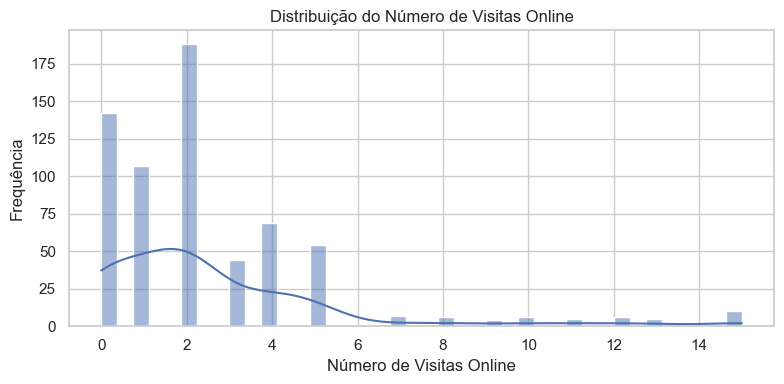

In [286]:
# Histograma do n√∫mero de visitas online:
plt.figure(figsize=(8, 4))
sns.histplot(df['Total_visits_online'], bins=40, kde=True)
plt.title('Distribui√ß√£o do N√∫mero de Visitas Online')
plt.xlabel('N√∫mero de Visitas Online')
plt.ylabel('Frequ√™ncia')
plt.tight_layout()
plt.show()

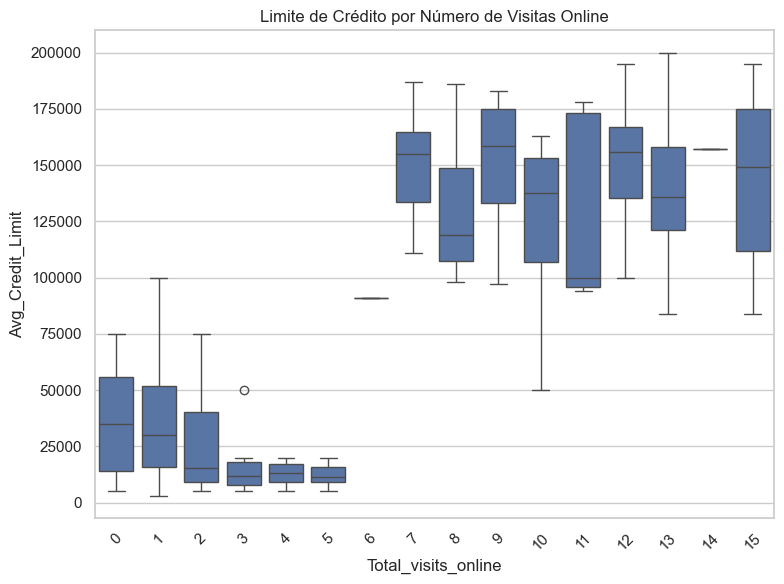

In [288]:
# Boxplot dos limites por n√∫mero de visitas online:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Total_visits_online', y='Avg_Credit_Limit')
plt.xticks(rotation=45)
plt.title('Limite de Cr√©dito por N√∫mero de Visitas Online')
plt.tight_layout()
plt.show()

In [290]:
# Scatter plot entre 'Avg_Credit_Limit' e 'Total_visits_online':
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="Total_visits_online", y="Avg_Credit_Limit", color="blue", alpha=0.7)

plt.title("Rela√ß√£o entre Total de Visitas Online e Limite M√©dio de Cr√©dito")
plt.xlabel("Total de Visitas Online")
plt.ylabel("Limite M√©dio de Cr√©dito")
plt.tight_layout()
plt.show()


In [292]:
# Boxplot dos limites por n√∫mero de chamadas:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Total_calls_made', y='Avg_Credit_Limit')
plt.xticks(rotation=45)
plt.title('Limite de Cr√©dito por N√∫mero de Chamadas Feitas')
plt.tight_layout()
plt.show()

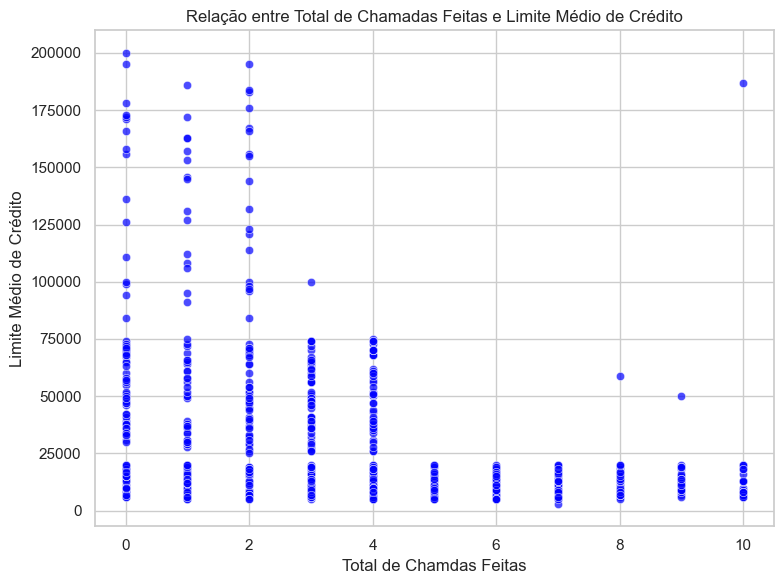

In [294]:
# Scatter plot entre 'Avg_Credit_Limit' e 'Total_calls_made':
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="Total_calls_made", y="Avg_Credit_Limit", color="blue", alpha=0.7)

plt.title("Rela√ß√£o entre Total de Chamadas Feitas e Limite M√©dio de Cr√©dito")
plt.xlabel("Total de Chamdas Feitas")
plt.ylabel("Limite M√©dio de Cr√©dito")
plt.tight_layout()
plt.show()

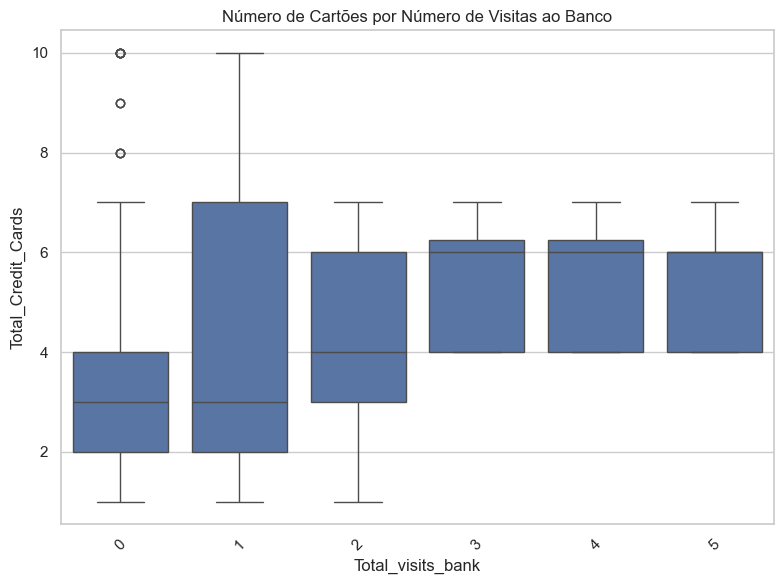

In [296]:
# Boxplot do n√∫mero de cart√µes por n√∫mero de visitas ao banco:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Total_visits_bank', y='Total_Credit_Cards')
plt.xticks(rotation=45)
plt.title('N√∫mero de Cart√µes por N√∫mero de Visitas ao Banco')
plt.tight_layout()
plt.show()

In [298]:
# Scatter plot entre 'Total_Credit_Cards' e 'Total_visits_bank':
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="Total_visits_bank", y="Total_Credit_Cards", color="blue", alpha=0.7)

plt.title("Rela√ß√£o entre Total de Visitas ao Banco e N√∫mero de Cart√µes")
plt.xlabel("Total de Visitas ao Banco")
plt.ylabel("Total de Cart√µes")
plt.tight_layout()
plt.show()

In [300]:
# Boxplot do n√∫mero de cart√µes por n√∫mero de chamadas ao banco:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Total_calls_made', y='Total_Credit_Cards')
plt.xticks(rotation=45)
plt.title('N√∫mero de Cart√µes por N√∫mero de Chamadas ao Banco')
plt.tight_layout()
plt.show()

In [302]:
# Scatter plot entre 'Total_Credit_Cards' e 'Total_calls_made':
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="Total_calls_made", y="Total_Credit_Cards", color="blue", alpha=0.7)

plt.title("Rela√ß√£o entre Total de Chamadas Feitas e N√∫mero de Cart√µes")
plt.xlabel("Total de Chamadas Feitas")
plt.ylabel("Total de Cart√µes")
plt.tight_layout()
plt.show()

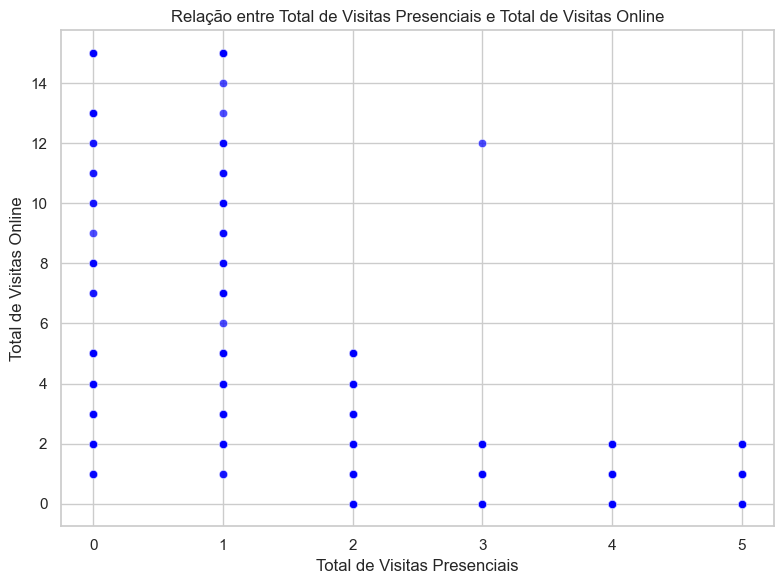

In [304]:
# Scatter plot entre 'Total_visits_bank' e 'Total_visits_online':
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="Total_visits_bank", y="Total_visits_online", color="blue", alpha=0.7)

plt.title("Rela√ß√£o entre Total de Visitas Presenciais e Total de Visitas Online")
plt.xlabel("Total de Visitas Presenciais")
plt.ylabel("Total de Visitas Online")
plt.tight_layout()
plt.show()

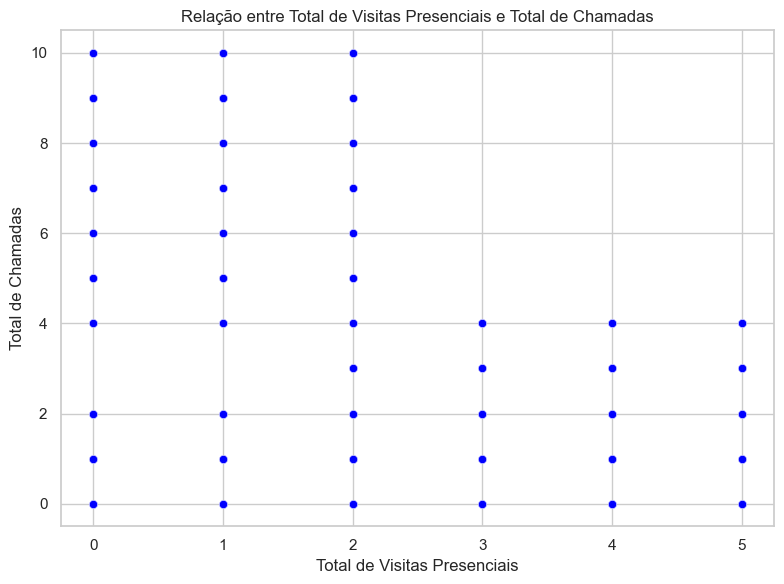

In [306]:
# Scatter plot entre 'Total_visits_bank' e 'Total_calls_made':
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="Total_visits_bank", y="Total_calls_made", color="blue", alpha=0.7)

plt.title("Rela√ß√£o entre Total de Visitas Presenciais e Total de Chamadas")
plt.xlabel("Total de Visitas Presenciais")
plt.ylabel("Total de Chamadas")
plt.tight_layout()
plt.show()

Percebemos, pelos gr√°ficos acima, que possu√≠mos alguns dados distribu√≠dos de maneira heterog√™nea, n√£o temos muitos *outliers* e as correla√ß√µes lineares se mostraram verdadeiras. Portanto, percebi que posso aplicar o PCA para reduzir a dimensionalidade destes dados e, em seguida, clusteriz√°-los, assim percebendo padr√µes de clientes.

**Observa√ß√£o**: a constata√ß√£o da linearidade nas correla√ß√µes √© de suma import√¢ncia, pois o PCA √© uma t√©cnica essencialmente linear, ou seja, o PCA n√£o lida bem com relac√µes n√£o lineares e, para estas, possu√≠mos outros algoritmos e t√©cnicas.

## Principal Component Analysis (PCA)
Antes de aplicar o PCA, vou fazer Feature Scalling nos dados, para que escalas diferentes n√£o atrapalhem a redu√ß√£o de dimensionalidade. Para isso, vou desprezar a coluna 'Customer Key', pois s√≥ serve de identificador, e normalizar as demais usando Standard Scaler. 

In [310]:
# Selecionando as colunas que vou normalizar:
colunas = ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']

scaler = StandardScaler()

df_normalizado = scaler.fit_transform(df[colunas])

df_normalizado = pd.DataFrame(df_normalizado, columns=colunas, index=df.index)

pca = PCA()
pca.fit(df_normalizado) 

# Vari√¢ncia explicada por cada componente
variancia = pca.explained_variance_ratio_

### Como decidir o n√∫mero de dimens√µes?

Para determinar quantas componentes principais manter ap√≥s o PCA, utiliza-se o **M√©todo do Cotovelo**:

1. **C√°lculo da Vari√¢ncia Explicada**  
   Para cada componente \(i\), calcula-se a vari√¢ncia explicada como:

   $$
   \mathrm{Vari√¢ncia}_i \;=\; \frac{\lambda_i}{\displaystyle\sum_{j=1}^{n} \lambda_j}
   $$

   em que $(\lambda_i)$ √© o autovalor da $i$-√©sima componente.

2. **Gr√°fico de Vari√¢ncia vs. N√∫mero de Componentes**  
   Plota-se a vari√¢ncia explicada (ou cumulativa) em fun√ß√£o do n√∫mero de componentes. A curva normalmente decresce rapidamente no in√≠cio e depois se estabiliza.

3. **Identifica√ß√£o do Cotovelo**  
   O ‚Äúcotovelo‚Äù √© o ponto em que a curva come√ßa a se achatar, indicando que componentes adicionais geram ganhos marginais de vari√¢ncia. Esse √© o n√∫mero ideal de dimens√µes a manter.

> **Vantagem:** aplica um crit√©rio visual e objetivo para balancear simplifica√ß√£o do modelo e reten√ß√£o de informa√ß√£o relevante.


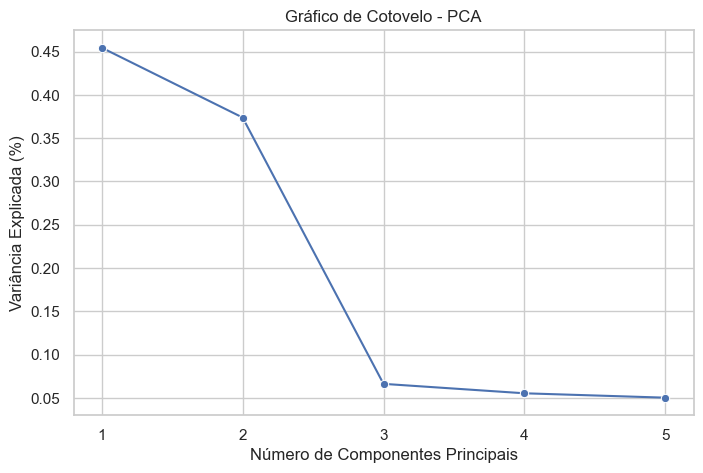

In [313]:
# Gr√°fico do cotovelo:
plt.figure(figsize=(8, 5))
sns.lineplot(x=range(1, len(variancia) + 1), y=variancia, marker='o')

plt.xlabel('N√∫mero de Componentes Principais')
plt.ylabel('Vari√¢ncia Explicada (%)')
plt.title('Gr√°fico de Cotovelo - PCA')
plt.xticks(range(1, len(variancia) + 1))
plt.show()

Como podemos notar acima, apesar da curva se estabilizar a partir da 3¬™ componente principal, as duas componentes principais j√° representam aproximadamente 82% da vari√¢ncia. Sendo assim, irei reduzir os dados com o PCA para o espa√ßo $ \mathbb{R}^2 $.


In [316]:
# Reduzindo dimens√£o:

# Inicializando o PCA para 2 dimens√µes:
pca = PCA(n_components=2)

# Aplicando o PCA:
dados_R2 = pca.fit_transform(df_normalizado)

# Transformando os dados reduzidos em df:
dados_R2 = pd.DataFrame(dados_R2, columns=['PCA1', 'PCA2'], index=df.index)

In [318]:
dados_R2.head()

PCA1      PCA2
0  1.624790 -0.418682
1  1.009123 -1.493896
2 -1.087188  0.044760
3  1.367327 -2.040991
4  0.628004 -0.612780

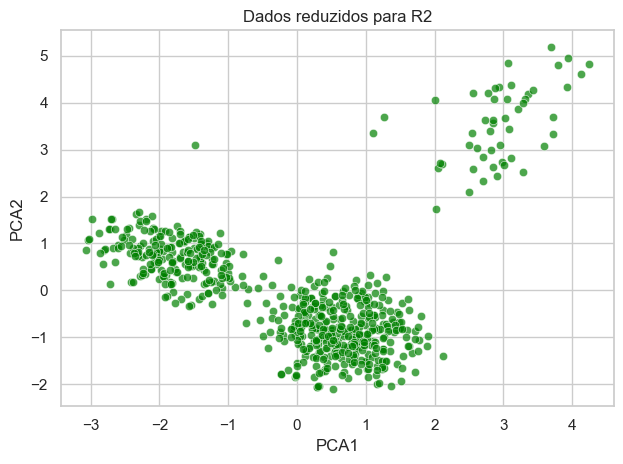

In [320]:
# Plotando os dados reduzidos:
sns.scatterplot(data=dados_R2, x="PCA1", y="PCA2", color="green", alpha=0.7)

plt.title("Dados reduzidos para R2")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.tight_layout()
plt.show()

Perceba como, s√≥ ao olhar, podemos perceber clusters se formando. Podemos dizer que, "pelo olho", o n√∫mero ideal de clusters seria 3. Por√©m, quando n√£o podemos visualizar os dados para isso, podemos fazer uma esp√©cie de cotovelo de clusters.<br>
Como temos dados que, visualmente, j√° se destacam, usarei o algoritmo de K-Means para clusterizar estes dados.

### M√©todo do Cotovelo para Clustering

O **m√©todo do cotovelo** √© uma t√©cnica utilizada para determinar o n√∫mero ideal de clusters em uma an√°lise de clustering, como o **KMeans**. A ideia principal √© calcular a **in√©rcia** (soma das dist√¢ncias quadradas dentro de cada cluster) para diferentes valores de **K** (n√∫mero de clusters) e identificar onde a curva ‚Äúfaz um cotovelo‚Äù.

1. **C√°lculo da In√©rcia**  
   Para cada K, ajusta-se o KMeans e obt√©m-se a in√©rcia, que mede o qu√£o pr√≥ximos os pontos est√£o do centro de seus clusters.  
   
2. **Plotagem do Gr√°fico**  
   Plotamos a in√©rcia em fun√ß√£o de K. Geralmente, a in√©rcia diminui conforme aumentamos K, mas chega um ponto em que o ganho de redu√ß√£o √© marginal.  

3. **Identifica√ß√£o do Cotovelo**  
   O ‚Äúcotovelo‚Äù √© o ponto em que a curva come√ßa a se estabilizar ‚Äî ou seja, onde o benef√≠cio de adicionar mais clusters se torna pequeno. Esse K corresponde ao n√∫mero ideal de clusters.  

> **Vantagem:** fornece um crit√©rio formal para escolher K, evitando decis√µes arbitr√°rias.  


C:\Users\emine\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\emine\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\emine\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\emine\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

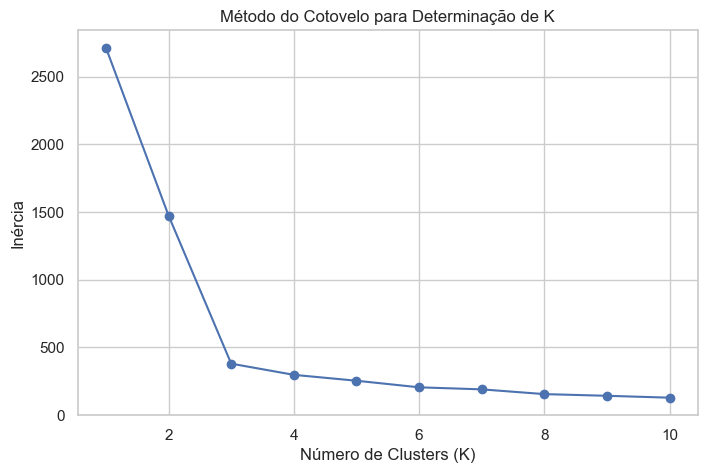

In [324]:
# Definindo o intervalo de valores de K (n√∫mero de clusters):
K_range = range(1, 11)  # de 1 a 10 clusters

# Lista para armazenar as in√©rcias:
inercia = []

# Calculando a in√©rcia para cada K:
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(dados_R2)
    inercia.append(kmeans.inertia_)

# Plotando o gr√°fico do m√©todo do cotovelo:
plt.figure(figsize=(8, 5))
plt.plot(K_range, inercia, marker='o', linestyle='-', color='b')
plt.xlabel('N√∫mero de Clusters (K)')
plt.ylabel('In√©rcia')
plt.title('M√©todo do Cotovelo para Determina√ß√£o de K')
plt.grid(True)
plt.show()

Perceba que o cotovelo do gr√°fico confirma nossa hip√≥tese visual: a estabiliza√ß√£o ocorre com 3 clusters, ou seja, este √© o n√∫mero ideal de clusters para os dados que temos.

C:\Users\emine\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


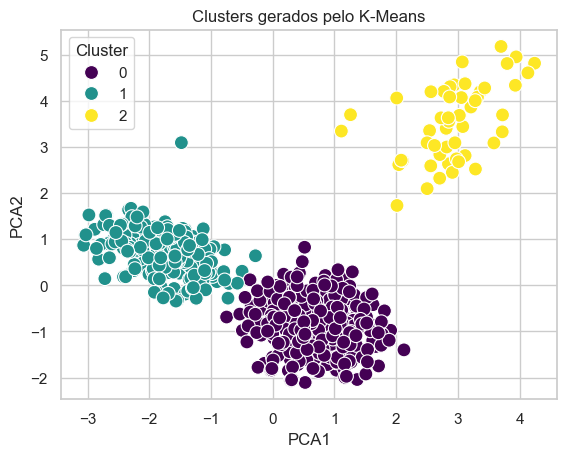

In [327]:
# Clusterizando em 3 clusters:
kmeans = KMeans(n_clusters=3, random_state=42)
dados_R2['Cluster'] = kmeans.fit_predict(dados_R2)  # Adicionando a coluna 'Cluster' ao DataFrame

# Visualizando os clusters:
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=dados_R2, palette='viridis', s=100)
plt.title('Clusters gerados pelo K-Means')
plt.show()

Perceba como os 3 clusters formados ap√≥s o K-Means est√£o bem definidos no gr√°fico. Isso significa que existem 3 grupos, bem definidos, de clientes. Agora, vou adicionar a coluna 'Cluster' ao df original e, ap√≥s isso, tentar ver algum sentido ou padr√£o nos grupos. 

In [346]:
# Agora, vou adicionar a coluna de cluster ao df original:
df['Cluster'] = dados_R2['Cluster'].values

In [348]:
df.head()

Customer Key  Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0         11265             51000                   7                  3   
1         11398             12000                   6                  5   
2         11412             19000                   2                  2   
3         11466              9000                   7                  5   
4         11562             38000                   4                  3   

   Total_visits_online  Total_calls_made  Cluster  
0                    2                 0        0  
1                    2                 1        0  
2                    3                 4        1  
3                    0                 0        0  
4                    2                 0        0

In [356]:
df_medias = df.groupby('Cluster')[['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']].mean().reset_index()
df_medias.sort_values(by='Avg_Credit_Limit')

Cluster  Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
1        1      12390.134529            2.421525           0.941704   
0        0      33787.958115            5.518325           3.494764   
2        2     141040.000000            8.760000           0.660000   

   Total_visits_online  Total_calls_made  
1             3.560538          6.856502  
0             0.986911          2.010471  
2            10.900000          1.280000

### üéØ An√°lise dos Grupos de Clientes por Cluster

A an√°lise dos dados agrupados por **cluster** revela que os grupos foram segmentados, principalmente, com base na **m√©dia do limite de cr√©dito**. 

Temos, portanto, tr√™s grupos distintos:
- üí≥ **Baixo limite de cr√©dito**
- üí≥ **Limite intermedi√°rio**
- üí≥ **Alto limite de cr√©dito**

Essa classifica√ß√£o est√° **diretamente relacionada ao n√∫mero m√©dio de cart√µes de cr√©dito**: quanto maior o limite, maior a quantidade de cart√µes, como j√° foi observado na An√°lise Explorat√≥ria.

---

### üîç Comportamento por Canal de Atendimento

1. **Grupo com menor limite de cr√©dito**:
   - Usa **pouco** o canal **presencial**;
   - Usa **moderadamente** o canal **online**;
   - Utiliza **principalmente** o canal **telef√¥nico**.

2. **Grupo com limite intermedi√°rio**:
   - Usa **moderadamente** os canais **presencial** e **telef√¥nico**;
   - Quase **n√£o utiliza** o canal **online**.

3. **Grupo com maior limite de cr√©dito**:
   - Usa **intensamente** o canal **online**;
   - Utiliza **pouco** o canal **telef√¥nico**;
   - Quase **n√£o usa** o canal **presencial**.

---

### üí° Aplica√ß√µes Estrat√©gicas

Essa segmenta√ß√£o pode ser extremamente √∫til para diversas a√ß√µes estrat√©gicas do banco:

1. **Planejamento de investimentos**: determinar quais canais devem receber mais aten√ß√£o e recursos, com foco no tipo de clientes que o banco deseja captar ou fidelizar;
2. **Campanhas de marketing personalizadas**: alinhar a abordagem com os canais preferenciais de cada grupo, focando em melhorias que realmente importem para aquele setor de clientes;
3. **Melhoria da experi√™ncia do cliente**: adaptar os canais de atendimento √†s expectativas e comportamentos dos principais grupos de clientes.
